# Running sentiment analysis on the review text - TextBlob sentiment analyzer
References
- [Sentiment analysis for data science](https://medium.com/@nikitasilaparasetty/twitter-sentiment-analysis-for-data-science-using-python-in-2022-6d5e43f6fa6e).
- [GitHub](https://github.com/nikitasilaparasetty/Twitter-Sentiment-Analysis-Projects-2022-) for the above medium blog post.
- [TextBlob](https://textblob.readthedocs.io/en/dev/index.html): Simplified Text Processing - provides API for diving into common NLP tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation and more.

In [1]:
# Import the necessary libraries
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd

## Data preparation
Load and clean the review text data.

In [2]:
data = pd.read_csv('steam_reviews.csv')
data.head()

,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,1611381629,1611381629,True,0,...,True,False,False,76561199095369542,6,2,1909.0,1448.0,1909.0,1.611343e+09
1,1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,1611381030,1611381030,True,0,...,True,False,False,76561198949504115,30,10,2764.0,2743.0,2674.0,1.611386e+09
2,2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,1611380800,1611380800,True,0,...,True,False,False,76561199090098988,5,1,1061.0,1061.0,1060.0,1.611384e+09
3,3,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",1611379970,1611379970,True,0,...,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1.611384e+09
4,4,292030,The Witcher 3: Wild Hunt,85184287,schinese,大作,1611379427,1611379427,True,0,...,True,False,False,76561199028326951,7,4,217.0,42.0,217.0,1.610788e+09


Create a dataframe with only the required columns, i.e. features that are necessary to link sentiment score to review for visualisation.

In [3]:
df = data[['app_id', 'app_name', 'review_id', 'language', 'review', 'timestamp_created']]
print("No. of reviews in all languages: " + str(df.count()[0]))
df.head()

No. of reviews in all languages: 21747371


,app_id,app_name,review_id,language,review,timestamp_created
0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,1611381629
1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,1611381030
2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,1611380800
3,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",1611379970
4,292030,The Witcher 3: Wild Hunt,85184287,schinese,大作,1611379427


Fetch the reviews written in english and filter out the reviews that are in other languages.

In [4]:
df = df.query("language == 'english'").reset_index(drop=True)
print("No. of reviews in english: " + str(df.count()[0]))
df.head()

No. of reviews in english: 9635437


,app_id,app_name,review_id,language,review,timestamp_created
0,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",1611379970
1,292030,The Witcher 3: Wild Hunt,85184171,english,"good story, good graphics. lots to do.",1611379264
2,292030,The Witcher 3: Wild Hunt,85184064,english,"dis gud,",1611379091
3,292030,The Witcher 3: Wild Hunt,85180436,english,favorite game of all time cant wait for the Ne...,1611373086
4,292030,The Witcher 3: Wild Hunt,85179753,english,Why wouldn't you get this,1611371978


Create a function to clean the reviews and remove stopwords and unnecessary characters

In [26]:
def clean_review(review):
    if type(review) == float:
        return ""
    r = review.lower()
    r = re.sub("'", "", r) # This is to avoid removing contractions in english
    r = re.sub("@[A-Za-z0-9_]+","", r)
    r = re.sub("#[A-Za-z0-9_]+","", r)
    r = re.sub(r'http\S+', '', r)
    r = re.sub('[()!?]', ' ', r)
    r = re.sub('\[.*?]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = r.split()
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
    r = [w for w in r if not w in stopwords]
    r = " ".join(word for word in r)
    return r

In [29]:
cleaned = [clean_review(rv) for rv in df.review]

Append the cleaned review text to the above pandas dataframe.

In [30]:
df['review_cleaned'] = pd.Series(cleaned)

Write the dataframe to a csv file to avoid memory issues going forward.

In [31]:
df.to_csv('steam_review_cleaned_english.csv')

## Sentiment analysis
If you are running low on memory, restart the kernel before proceeding.

In [47]:
df = pd.read_csv('steam_review_cleaned_english.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9635437 entries, 0 to 9635436
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Unnamed: 0      int64 
 1   app_id          int64 
 2   app_name        object
 3   review_id       int64 
 4   language        object
 5   review          object
 6   review_cleaned  object
dtypes: int64(3), object(4)
memory usage: 514.6+ MB


In [4]:
sentiment_objects = [TextBlob(review) for review in df.review_cleaned.astype(str)]

Fetch the sentiment/polarity score for the reviews. The polarity score is a float within the range [-1.0, 1.0].
-1 indicates negative sentiment.
+1 indicates positive sentiment.


I iterated over a million results at a time and wrote the polarity score results to a file due to memory and time complexity on my local machine. The ranges I used are:
- 0 : 1,000,000
- 1,000,000 : 2,000,000
- 2,000,000 : 3,000,000
- 3,000,000 : 4,000,000
- 4,000,000 : 5,000,000
- 5,000,000 : 6,000,000
- 6,000,000 : 7,000,000
- 7,000,000 : 8,000,000
- 8,000,000 : 9,000,000
- 9,000,000 :

In [ ]:
polarity = []
for i, review in enumerate(sentiment_objects[9000000:]):
    polarity.append(review.sentiment.polarity)
    print(i)

In [28]:
polarity_df = pd.DataFrame(polarity)
polarity_df.head()

,0
0,0.0
1,0.0
2,0.5
3,0.0
4,0.7


In [29]:
polarity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635437 entries, 0 to 635436
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       635437 non-null  float64
dtypes: float64(1)
memory usage: 4.8 MB


In [30]:
polarity_df.to_csv('polarity_final.csv', header=False, index=False)

## Combine the datasets

In [36]:
polarity_1000000 = pd.read_csv('polarity_1000000.csv', header=None)
polarity_2000000 = pd.read_csv('polarity_2000000.csv', header=None)
polarity_3000000 = pd.read_csv('polarity_3000000.csv', header=None)
polarity_4000000 = pd.read_csv('polarity_4000000.csv', header=None)
polarity_5000000 = pd.read_csv('polarity_5000000.csv', header=None)
polarity_6000000 = pd.read_csv('polarity_6000000.csv', header=None)
polarity_7000000 = pd.read_csv('polarity_7000000.csv', header=None)
polarity_8000000 = pd.read_csv('polarity_8000000.csv', header=None)
polarity_9000000 = pd.read_csv('polarity_9000000.csv', header=None)
polarity_final = pd.read_csv('polarity_final.csv', header=None)

In [37]:
polarity_1000000.head()

,0
0,0.666667
1,0.700000
2,0.000000
3,0.050000
4,0.000000


In [43]:
polarity = polarity_1000000\
    .append(polarity_2000000)\
    .append(polarity_3000000)\
    .append(polarity_4000000)\
    .append(polarity_5000000)\
    .append(polarity_6000000)\
    .append(polarity_7000000)\
    .append(polarity_8000000)\
    .append(polarity_9000000)\
    .append(polarity_final)\
    .reset_index(drop=True)

/var/folders/42/m13vsnkx0qz76w0rdpzc4qb00000gn/T/ipykernel_97905/260745633.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(polarity_2000000)\
/var/folders/42/m13vsnkx0qz76w0rdpzc4qb00000gn/T/ipykernel_97905/260745633.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(polarity_3000000)\
/var/folders/42/m13vsnkx0qz76w0rdpzc4qb00000gn/T/ipykernel_97905/260745633.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(polarity_4000000)\
/var/folders/42/m13vsnkx0qz76w0rdpzc4qb00000gn/T/ipykernel_97905/260745633.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(polarity_5000000)\
/var/folders/42/m13vsnkx0qz7

In [41]:
polarity.head()

,0
0,0.666667
1,0.700000
2,0.000000
3,0.050000
4,0.000000


In [44]:
polarity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9635437 entries, 0 to 9635436
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
dtypes: float64(1)
memory usage: 73.5 MB


## Append polarity to the main dataframe
Link each polarity score to the corresponding review text.

In [48]:
df.head()

,app_id,app_name,review_id,language,review,review_cleaned
0,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",one best rpgs all time worthy any collection
1,292030,The Witcher 3: Wild Hunt,85184171,english,"good story, good graphics. lots to do.",good story good graphics lots do
2,292030,The Witcher 3: Wild Hunt,85184064,english,"dis gud,",dis gud
3,292030,The Witcher 3: Wild Hunt,85180436,english,favorite game of all time cant wait for the Ne...,favorite game all time cant wait nexgen versiion
4,292030,The Witcher 3: Wild Hunt,85179753,english,Why wouldn't you get this,why wouldnt you get this


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9635437 entries, 0 to 9635436
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   app_id          int64 
 1   app_name        object
 2   review_id       int64 
 3   language        object
 4   review          object
 5   review_cleaned  object
dtypes: int64(2), object(4)
memory usage: 514.6+ MB


In [51]:
df['polarity'] = polarity
df.head()

,app_id,app_name,review_id,language,review,review_cleaned,polarity
0,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",one best rpgs all time worthy any collection,0.666667
1,292030,The Witcher 3: Wild Hunt,85184171,english,"good story, good graphics. lots to do.",good story good graphics lots do,0.700000
2,292030,The Witcher 3: Wild Hunt,85184064,english,"dis gud,",dis gud,0.000000
3,292030,The Witcher 3: Wild Hunt,85180436,english,favorite game of all time cant wait for the Ne...,favorite game all time cant wait nexgen versiion,0.050000
4,292030,The Witcher 3: Wild Hunt,85179753,english,Why wouldn't you get this,why wouldnt you get this,0.000000


## Save the results in a file
Drop the 'review' column as its causing issues in a csv file due to the 'review' column data containing commas.

In [13]:
df.drop('review', axis=1, inplace=True)
df.head()

,app_id,app_name,review_id,language,timestamp_created,polarity,review_cleaned
0,292030,The Witcher 3: Wild Hunt,85184605,english,1611379970,0.666667,one best rpgs all time worthy any collection
1,292030,The Witcher 3: Wild Hunt,85184171,english,1611379264,0.700000,good story good graphics lots do
2,292030,The Witcher 3: Wild Hunt,85184064,english,1611379091,0.000000,dis gud
3,292030,The Witcher 3: Wild Hunt,85180436,english,1611373086,0.050000,favorite game all time cant wait nexgen versiion
4,292030,The Witcher 3: Wild Hunt,85179753,english,1611371978,0.000000,why wouldnt you get this


In [14]:
df.to_csv('sentiment_analysis_results_english.csv')

## Visualisation of the results (Exploratory)
Visualise the polarity ratio among the entire set of english reviews.

In [18]:
polarity = pd.Series(df['polarity'])

In [12]:
positive = 0
negative = 0
neutral = 0

for i in polarity:
    if i > 0:
        positive = positive + 1
    elif i < 0:
        negative = negative + 1
    else:
        neutral = neutral + 1

print('Positive: ', positive)
print('Negative: ', negative)
print('Neutral', neutral)

Positive:  5830759
Negative:  2079037
Neutral 1725641


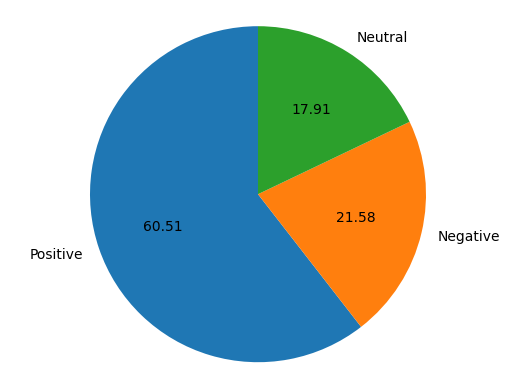

In [13]:
pieLabels=["Positive","Negative","Neutral"]
populationShare=[positive, negative, neutral]
figureObject, axesObject = plt.subplots()
axesObject.pie(populationShare, labels=pieLabels, autopct='%1.2f', startangle=90)
axesObject.axis('equal')
plt.show()